# Advanced spatial joins

## Lecture objectives

1. Explore different spatial relationships (predicates)
2. Practice troubleshooting spatial joins

## Other types of spatial relationships

The `intersects` operator, which we used in the previous lecture, is one of the most common spatial predicates, i.e. the relationship between two geometries. It is excellent if you want to know whether a point is within (or on the boundary) of a polygon. In general, each point will match to one polygon, but you need to be careful if your points are on the boundary and thus intersect with two polygons.

Let's start by loading two of the datasets we used in the last lecture. This is exactly the same code.

In [2]:
import geopandas as gpd
import pandas as pd

pantryDf = pd.read_csv('../data/Food_Resources_in_California.csv')
pantryDf = pantryDf[pantryDf.County=='Los Angeles']

# convert to a GeoDataFrame
pantrygdf = gpd.GeoDataFrame(
    pantryDf, geometry=gpd.points_from_xy(pantryDf.Longitude, pantryDf.Latitude, 
                                          crs='EPSG:4326'))
# convert to 3857 to match the census data
pantrygdf.to_crs('EPSG:3857', inplace=True)

# get the census data for the City of LA
# B19019_001E is median household income
from cenpy import products
incomeDf = products.ACS(2017).from_county('Los Angeles, CA', level='tract',
                                        variables='B19019_001E')
incomeDf.rename(columns={'B19019_001E':'median_HH_income'}, inplace=True)

/Users/clairebekker/anaconda3/envs/uds/lib/python3.10/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)


Different predicates are defined in the `shapely` [documentation](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates). (`shapely` is working behind the scenes for many `geopandas` operations.)

In [3]:
print(incomeDf.sindex.valid_query_predicates)

{'overlaps', None, 'touches', 'crosses', 'contains_properly', 'within', 'intersects', 'covered_by', 'covers', 'contains'}


Let's look at the number of rows that are produced with three different predicates: intersects, contains, and within.

How do you explain the different results below?

In [4]:
print('There are {} pantries and {} tracts.'.format(len(pantrygdf), len(incomeDf)))

pantries_intersects = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='intersects')
print('Using intersects: {} rows'.format(len(pantries_intersects)))

pantries_contains = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='contains')
print('Using contains: {} rows'.format(len(pantries_contains)))

pantries_within = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='within')
print('Using within: {} rows'.format(len(pantries_within)))

There are 211 pantries and 2346 tracts.
Using intersects: 209 rows
Using contains: 209 rows
Using within: 0 rows


Intersects and contains return the same number of rows. If a census tract (a polygon) intersects a pantry (a point geometry), it also contains it.

But a census tract is not within a pantry. A polygon cannot be within a point (it's too big!) 

## Troubleshooting spatial joins

Also note that we have fewer join results than pantries. Why? A good guess would be that some pantries are physically outside the county (the "county" field notwithstanding).

<div class="alert alert-block alert-info">
<strong>Thought exercise:</strong> How would you verify that the missing pantries are outside the county?
</div>

We could map them. But note that the pantries dataset has a County field. So let's do `groupby` and ask for the size of each group. (All of the rows should be Los Angeles county because we filtered when we loaded in the dataset, but maybe we made a mistake?)

In [5]:
pantrygdf.groupby('County').size()

County
Los Angeles    211
dtype: int64

Hmm. So either all the pantries are within the county, or there is an error in the `County` column. Or our join is going wrong.

Let's map it and take a look. Note that we use the `alpha` parameter to adjust the transparency of both the census tracts and the basemap, making it easier to see the intersection.

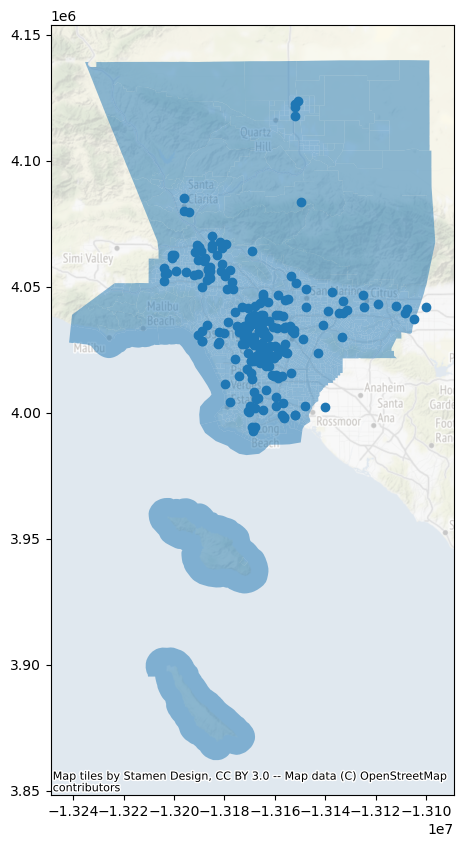

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
pantrygdf.plot(ax=ax)
incomeDf.plot(ax=ax, alpha=0.5) # 50% opacity
ctx.add_basemap(ax=ax, alpha=0.3) # 30% opacity

Aha. It looks like two of them are just outside the boundary. Probably, the `County` field was misspecified, or the location is imprecise. 

Let's look at the culprits. The `difference` function, which works on a pandas `Index`, is useful here. It's a set-theoretic operation, which looks for the elements that are in one index but not other. [Read about it here.](https://pandas.pydata.org/docs/reference/api/pandas.Index.difference.html)

In [6]:
pantrygdf.index.difference(pantries_intersects.index)

Index([315, 329, 331, 333, 334, 335, 336, 337, 338, 339,
       ...
       531, 532, 533, 534, 535, 536, 537, 538, 539, 540],
      dtype='int64', length=189)

OK, something went wrong. We should expect two rows (211 in `pantrygdf`, minus 209 in `pantries_intersects`).

In [7]:
pantries_intersects.head(2)

,GEOID,geometry,index_right,Name,Street Address,City,State,Zip Code,County,Phone,Description,Resource Type,Web Link,Notes,Latitude,Longitude
4,06037670100,"POLYGON ((-13172288.180 4000326.940, -13172287...",534,Wayside United Methodist Church,25904 Cayuga Ave.,Lomita,CA,90717,Los Angeles,(310) 326-4541,The agency provides emergency food for low-inc...,Food Pantry,https://www.211la.org/211search/more?site_id=1...,NaN,33.787858,-118.309293
7,06037296901,"POLYGON ((-13169228.570 3992447.710, -13169228...",373,Dana Middle School,1501 S. Cabrillo Ave.,San Pedro,CA,90731,Los Angeles,NaN,LOCAL DISTRICT SOUTH,Food Distribution Program,http://danams-lausd-ca.schoolloop.com/,NaN,33.730520,-118.294720


Aha. The spatial join created a new index, and put the original index in a column called `index_right`. Let's use this column instead. 

In [8]:
pantrygdf.index.difference(pantries_intersects.index_right)

Index([390, 400], dtype='int64')

What are these rows?

In [9]:
pantrygdf.loc[[390,400]]  

,Name,Street Address,City,State,Zip Code,County,Phone,Description,Resource Type,Web Link,Notes,Latitude,Longitude,geometry
390,Foothill Family Shelter,"1501 W. 9th St., Ste. D",Upland,CA,91786,Los Angeles,(909) 920-0453,The agency provides transitional shelter for h...,Food Pantry,https://www.211la.org/211search/more?site_id=1...,NaN,34.096378,-117.679776,POINT (-13100052.741 4041750.590)
400,Grateful Hearts,5420 Katella Ave.,Los Alamitos,CA,90720,Los Angeles,(562) 431-0880,The agency provides emergency food and volunte...,Food Pantry,https://www.211la.org/211search/more?site_id=1...,NaN,33.802645,-118.038262,POINT (-13139959.220 4002332.756)


Well, neither of these two cities are in Los Angeles County. (Upland is in San Bernadino, and Los Alamitos is in Orange.) So it's safe to ignore them, and work with the 209 pantries that were spatially joined.

The point here: spatial joins often throw up unexpected results. You'll have to do some detective work to figure out what goes wrong.

## Spatial attributes
We can access useful attributes of the geometry directly from `geopandas`. Areas, lengths, and bounding boxes are three examples.

Note that the units will be based on your projection. You probably don't want to measure distances or areas in degrees! But even a projection in meters can be distorted.

The best projection will vary locally. In the US, the State Plane coordinate systems are usually the best choice for local-level work. Los Angeles is in State Plane [California zone 5, which has an EPSG code of 3497](https://epsg.io/3497). Note the units are in meters. If you want feet, [try EPSG code 6424](https://epsg.io/6424). 

In [10]:
# in Web Mercator
print(incomeDf.crs)
print(incomeDf.geometry.area.head())

epsg:3857
0    7.738875e+06
1    1.123372e+07
2    8.097955e+06
3    4.417901e+06
4    2.109732e+06
dtype: float64


In [11]:
# in State Plane
print(incomeDf.to_crs('EPSG:3497').geometry.area.head())

0    5.331023e+06
1    7.745625e+06
2    5.577130e+06
3    3.048855e+06
4    1.453802e+06
dtype: float64


For a polygon, length is the perimeter.

In [12]:
print(incomeDf.geometry.to_crs('EPSG:3497').length.head()) 

0    14540.884384
1    14687.746494
2    11465.561243
3     7933.603469
4     7679.098699
dtype: float64


The projection is less important for the bounding box, as long as you know which one you are using. Here, we are still in Web Mercator. But lat/lon is often the easiest to work with.

In [13]:
print(incomeDf.geometry.bounds.head())

          minx        miny         maxx        maxy
0 -13181682.77  4000784.22 -13174779.07  4002561.03
1 -13176479.25  3994254.16 -13172438.46  3999217.28
2 -13174776.73  4000577.81 -13171983.72  4005221.94
3 -13173029.46  3989862.16 -13170339.53  3993258.07
4 -13172288.40  3998668.73 -13170038.86  4000578.48


In [14]:
print(incomeDf.to_crs('EPSG:4326').geometry.bounds.head())

         minx       miny        maxx       maxy
0 -118.413071  33.791085 -118.351054  33.804349
1 -118.366327  33.742320 -118.330028  33.779386
2 -118.351033  33.789544 -118.325943  33.824209
3 -118.335337  33.709506 -118.311173  33.734879
4 -118.328680  33.775290 -118.308472  33.789549


<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Intersects is the most common spatial predicate, but it's not always what you want.</li>
  <li>Use an an appropriate projection.</li>
  <li>As with any join, inspect your output. If it's not what you expect, computing summary statistics or mapping can help identify the problem.</li>
</ul>
</div>